## Реализация DecisionTree с нуля
____

### Источник: 
https://m.habr.com/ru/company/mailru/blog/438560/
___

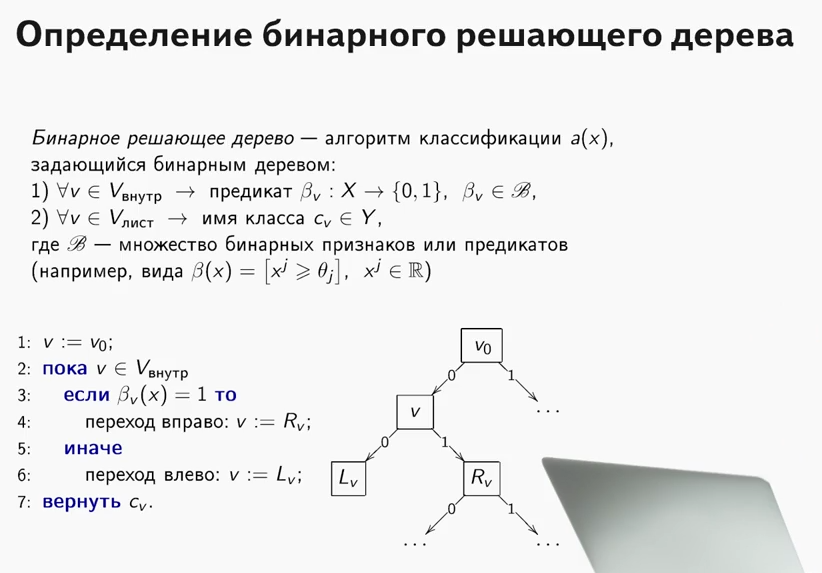

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn import datasets

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### 1. RegressionTree()

In [2]:
class RegressionTree():
    """
    Class solves regression task. 
    Based on recursive calls with return conditions.
    """
    import numpy as np
    
    def __init__(self, max_depth=3, n_epoch=10, min_size=10):
        # Maximum depth
        self.max_depth = max_depth
        # Minimum size of subtree
        self.min_size = min_size
        # Mean value on subtree
        self.value = 0
        # Index of best feature
        self.feature_idx = -1
        # Threshold of best feature
        self.feature_threshold = 0
        # Left child
        self.left = None
        # Right child
        self.right = None
        
    def fit(self, X, y):
        """
        Trains the tree. Returns trained model.
        """
        
        def mse(arr1, arr2):
            """
            Returns MSE metric between two arrays.
            """
            return ((arr1 - arr2) ** 2).sum()
        
        # Initialization
        self.value = y.mean()
        # Init MSE error
        base_error = mse(y, self.value)
        error = base_error
        # Flag of good split. "1" - made a good split, "0" - continue.
        flag = 0
        
        # Errors on left and right subtrees
        prev_error_left, prev_error_right = base_error, 0
        
        # Depth is zero.
        if self.max_depth <= 1:
            return
        
        dim_shape = X.shape[1]
        
        # Values on left and right subtrees
        left_value, right_value = 0, 0
        
        # Loop by feature
        for feature in range(dim_shape):
            # Sort features
            idxs = np.argsort(X[:, feature])
            # Numbers of samples on subtrees
            N = X.shape[0]
            N1, N2 = N, 0
            thres = 1
            
            while thres < N - 1:
                N1 -= 1
                N2 += 1
                
                idx = idxs[thres]
                x = X[idx, feature]
                
                # Skip when features are same
                if (thres < N - 1) and (x == X[idxs[thres + 1], feature]):
                    thres += 1
                    continue
                
                # Get data afrer splitting
                target_right = y[idxs][:thres]
                target_left = y[idxs][thres:]
                mean_right = y[idxs][:thres].mean()
                mean_left = y[idxs][thres:].mean()
                
                # Generate predict (mean value) for childrens 
                left_shape = target_left.shape[0]
                right_shape = target_right.shape[0]
                mean_left_arr = [mean_left for _ in range(left_shape)]
                mean_right_arr = [mean_right for _ in range(right_shape)]
                
                # Calculate mean weighted error
                prev_error_left = N1 / N * mse(target_left, mean_left_arr)
                prev_error_right = N2 / N * mse(target_right, mean_right_arr)
                
                # Condition to refresh if split completed:
                # Mean weighted error should be less than the current error in the tree
                if (prev_error_left + prev_error_right < error):
                    if (min(N1, N2) > self.min_size):
                        self.feature_idx = feature
                        self.feature_threshold = x
                        left_value = mean_left
                        rigth_value = mean_right
                        
                        flag = 1
                        error = prev_error_left + prev_error_right
                        
                thres += 1
                
        # Condition if best split was not found.
        if self.feature_idx == -1:
            return
        
        # Found best split. Initialization of children
        self.left = RegressionTree(self.max_depth - 1)
        self.left.value = left_value
        self.right = RegressionTree(self.max_depth - 1)
        self.right.value = right_value
        
        # Indexes of children
        idxs_l = (X[:, self.feature_idx] > self.feature_threshold)
        idxs_r = (X[:, self.feature_idx] <= self.feature_threshold)
        
        # Train
        self.left.fit(X[idxs_l, :], y[idxs_l])
        self.right.fit(X[idxs_r, :], y[idxs_r])
        
    def __predict(self, x):
        """
        Function generates predictions. Go down the tree by nodes and returns last self.value.
        """
        
        if self.feature_idx == -1:
            return self.value
        
        if x[self.feature_idx] > self.feature_threshold:
            return self.left.__predict(x)
        else:
            return self.right.__predict(x)
        
    def predict(self, X):
        """
        Same __predict for matrix case. Just iterates by row.
        """
        
        y = np.zeros(X.shape[0])
        
        for i in range(X.shape[0]):
            y[i] = self.__predict(X[i])
            
        return y

**Загрузим датасет для тестирования.**  
Датасет цен домов в Калифорнии из `sklearn.datasets`

In [3]:
data = datasets.fetch_california_housing()
X = np.array(data.data)
y = np.array(data.target)

In [4]:
%%time

A = RegressionTree(max_depth=2)
A.fit(X, y);

CPU times: user 1min 26s, sys: 284 ms, total: 1min 26s
Wall time: 2min 16s


In [5]:
%%time
model = DecisionTreeRegressor(max_depth=2)
model.fit(X, y)

CPU times: user 20.9 ms, sys: 9 µs, total: 20.9 ms
Wall time: 40.2 ms


DecisionTreeRegressor(max_depth=2)

**Первые результаты:**  

`RegressionTree` работает на несколько порядков дольше своего соотечественника из Sklearn в следствие долгого пересчёта ошибки, порождающего сложность в $O(N*log(N))$. Прибавим сюда используемый метод MSE со сложностью $O(N)$ и получим сложность нахождения точки ветвления в $O(N^2*log(N))$. 

### 1.1 RegressionTree() с быстрым пересчётом ошибки

Допустим на каком-то шаге уже есть ошибка, посчитанная для N объектов. Она имеет следующую формулу:  
$\sum_{i=1}^{n}(y_i - \frac{\sum_{i=1}^{N}y_i}{N})^2$.  
Мы хотим быстро получить ошибку следующего вида:  
$\sum_{i=1}^{N-1}(y_i - \frac{\sum_{i=1}^{N-1}y_i}{N-1})^2$

**Вывод:**  
...  
$\sum_{i=1}^{n}(y_i - \frac{\sum_{i=1}^{N}y_i}{N})^2 = 
\sum_{i=1}^{N-1}(\frac{(N - 1) y_i - \sum_{i=1}^{N-1}y_i}{N-1})^2 * (\frac{N-1}{N})^2 - \sum_{i=1}^{N-1}(2(\frac{(N-1)y_i-\sum_{i=1}^{N-1}y_i}{N})(\frac{y_N - y_i}{N}) - (\frac{y_N - y_i}{N})^2) + (y_N - \sum_{i=1}^{N}\frac{y_i}{N})^2$.

Теперь для пересчёта ошибки нам нужно хранить только суммы элементов справа и слева вдобавок к самому новому элементу, поступившему на вход. Сложность вычислений константная ~$O(1)$.

In [6]:
class RegressionTreeFastMSE():
    """
    Class solves regression task. MSE calculation by O(1).
    Based on recursive calls with return conditions.
    """
    import numpy as np
    
    def __init__(self, max_depth=3, n_epoch=10, min_size=10):
        # Maximum depth
        self.max_depth = max_depth
        # Minimum size of subtree
        self.min_size = min_size
        # Mean value on subtree
        self.value = 0
        # Index of best feature
        self.feature_idx = -1
        # Threshold of best feature
        self.feature_threshold = 0
        # Left child
        self.left = None
        # Right child
        self.right = None
        
    def fit(self, X, y):
        """
        Trains the tree. Returns trained model.
        """
        
        def mse(arr1, arr2):
            """
            Returns MSE metric between two arrays.
            """
            return ((arr1 - arr2) ** 2).sum()
        
        # Initialization
        self.value = y.mean()
        # Init MSE error
        base_error = mse(y, self.value)
        error = base_error
        flag = 0
        
        # Errors on left and right subtrees
        prev_error_left, prev_error_right = base_error, 0
        
        # Depth is zero.
        if self.max_depth <= 1:
            return
        
        dim_shape = X.shape[1]
        
        # Values on left and right subtrees
        left_value, right_value = 0, 0
        
        # Loop by feature
        for feature in range(dim_shape):
            prev_error1, prev_error2 = base_error, 0
            idxs = np.argsort(X[:, feature])
            
            # Variables for fast sum transfer between.
            mean1, mean2 = y.mean(), 0
            sum1, sum2 = y.sum(), 0
            
            N = X.shape[1]
            N1, N2 = N, 0
            thres = 1
            
            while thres < N - 1:
                N1 -= 1
                N2 += 1
                
                idx = idxs[thres]
                x = X[idx, feature]
                
                # Calculate deltas - for transfer by them
                delta1 = (sum1 - y[idx]) * 1.0 / N1 - mean1
                delta2 = (sum2 - y[idx]) * 1.0 / N2 - mean2
                
                # Increase sums
                sum1 -= y[idx]
                sum2 += y[idx]
                
                # Calculates errros by O(1)
                prev_error1 += delta1 ** 2 * N1
                prev_error1 -= (y[idx] - mean1) ** 2
                prev_error1 -= 2 * delta1 * (sum1 - mean1 * N1)
                mean1 = sum1 / N1
                
                prev_error2 += delta2 ** 2 * N2
                prev_error2 += (y[idx] - mean2) ** 2
                prev_error2 -= 2 * delta2 * (sum2 - mean2 * N2)
                mean2 = sum2 / N2
                
                # Skip values that are close to each other
                eps = 1e-5
                if (thres < N - 1) and (np.abs(x - X[idxs[thres + 1], feature]) < eps):
                    thres += 1
                    continue
                # Two conditions to make a split:
                #      1. Error becomes less;
                #      2. Number of values in leaf in minimal.
                if (prev_error1 + prev_error2 < error):
                    if (min(N1, N2) > self.min_size):
                        self.feature_idx = feature
                        self.feature_threshold = x
                        left_value = mean1
                        rigth_value = mean2
                        
                        flag = 1
                        error = prev_error1 + prev_error2
                        
                thres += 1
                
        # Condition of no split
        if self.feature_idx == -1:
            return
        
        self.left = RegressionTreeFastMSE(self.max_depth - 1)
        self.left.value = left_value
        
        self.rigth = RegressionTreeFastMSE(self.max_depth - 1)
        self.right.value = right_value
        
        idxs_l = (X[:, self.feature_idx] > self.feature_threshold)
        idxs_r = (X[:, self.feature_idx] <= self.feature_threshold)
        
        self.left.fit(X[idxs_l, :], y[idxs_l])
        self.right.fit(X[idxs_r, :], y[idxs_r])
        
        
    def __predict(self, x):
        """
        Function generates predictions. Go down the tree by nodes and returns last self.value.
        """
        
        if self.feature_idx == -1:
            return self.value
        
        if x[self.feature_idx] > self.feature_threshold:
            return self.left.__predict(x)
        else:
            return self.right.__predict(x)
        
    def predict(self, X):
        """
        Same __predict for matrix case. Just iterates by row.
        """
        
        y = np.zeros(X.shape[0])
        
        for i in range(X.shape[0]):
            y[i] = self.__predict(X[i])
            
        return y

*Повторим измерения времени*

In [7]:
%%time 
A = RegressionTreeFastMSE(max_depth=4, min_size=5)
A.fit(X, y)
test_mytree = A.predict(X)
test_mytree

CPU times: user 17.6 ms, sys: 11 µs, total: 17.6 ms
Wall time: 36.3 ms


array([2.06855817, 2.06855817, 2.06855817, ..., 2.06855817, 2.06855817,
       2.06855817])

In [8]:
%%time
model = DecisionTreeRegressor(max_depth=4)
model.fit(X, y)
test_sklearn = model.predict(X)
test_sklearn

CPU times: user 41.8 ms, sys: 0 ns, total: 41.8 ms
Wall time: 85.8 ms


array([4.3137005 , 4.3137005 , 4.20073852, ..., 0.96624431, 0.96624431,
       0.96624431])

### 1.3 RegressionTree() с линейной комбинацией признаков

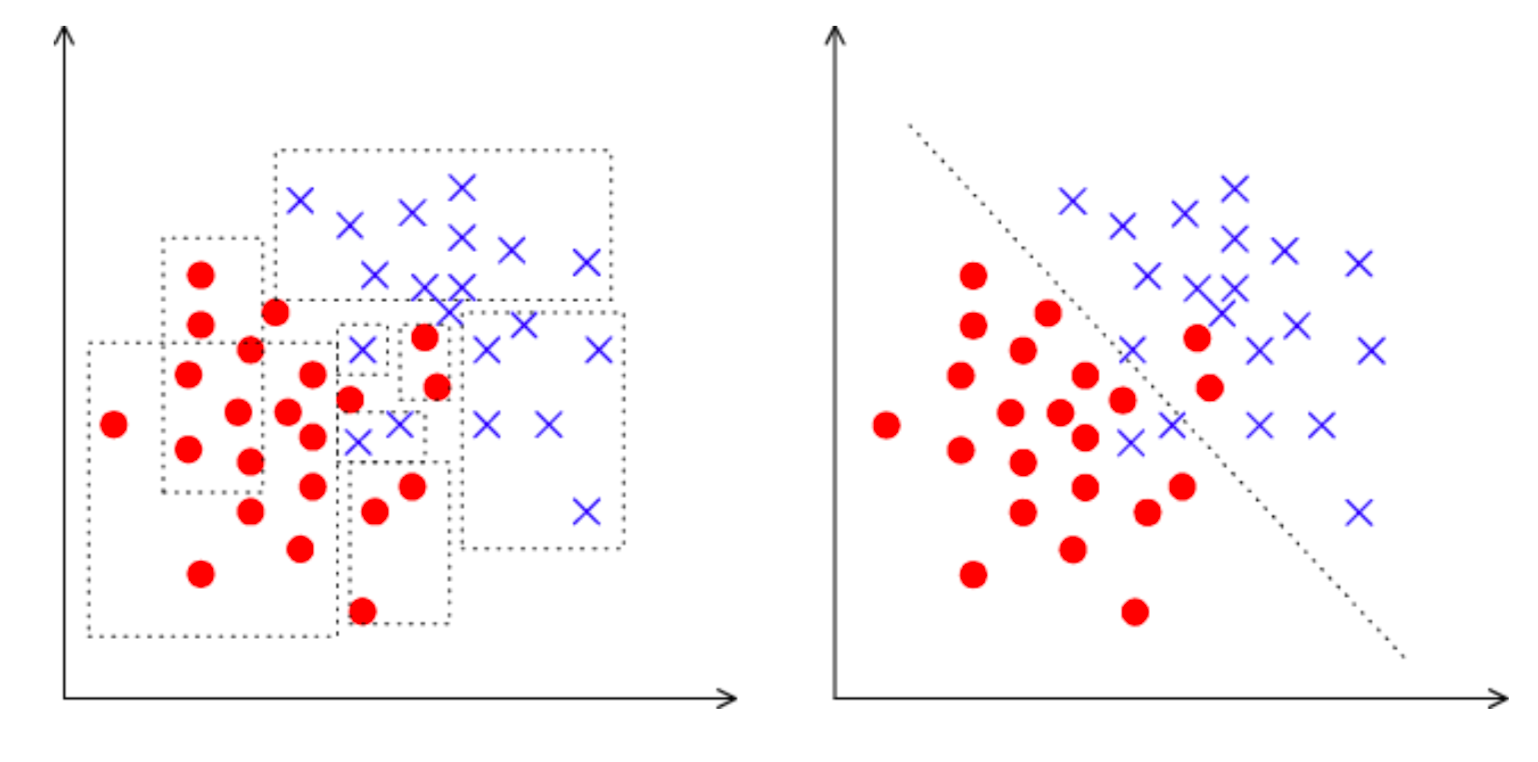

До этого мы фиксировали один параметр и смотрели только ортогональне разбиение пространства $f_{eat} < x$. Теперь будем смотреть $\sum_{i=1}^{K} b_i * a < x$, где $K < dim(пространства)$. 

Будем добавлять в качестве новых признаков, например, всевозможных комбинаций сумм признаков $i, j$, где $i < j$. Также воспользуемся `cython` дабы покрыть возросшую сложность алгоритма поиска.

In [9]:
%load_ext Cython

In [10]:
%%cython -a

import itertools
import numpy as np
cimport numpy as np
from itertools import *

cdef class RegressionTreeCython:
    
    cdef public int max_depth
    cdef public int feature_idx
    cdef public int min_size
    cdef public int averages
    
    cdef public np.float64_t feature_threshold
    cdef public np.float64_t value
    
    cpdef RegressionTreeCython left
    cpdef RegressionTreeCython right
    
    def __init__(self, max_depth=3, min_size=4, averages=1):
        
        self.max_depth = max_depth
        self.min_size = min_size
        self.value = 0
        self.averages = averages
        self.feature_idx = -1
        self.feature_threshold = 0
        self.left = None
        self.right = None
        
    def data_transform(self, np.ndarray[np.float64_t, ndim=2] X, list index_tuples):
        """
        Data transform - add new sum type features. 
        """
        for i in index_tuples:
            # Add sums, which indexes was gave as argument
            X = np.hstack((X, X[:, i[0]:(i[1] + 1)].sum(axis=1).reshape(X.shape[0], 1)))
        return X
    
    def fit(self, np.ndarray[np.float64_t, ndim=2] X, np.ndarray[np.float64_t, ndim=1] y):

        cpdef np.float64_t mean1 = 0.0
        cpdef np.float64_t mean2 = 0.0
        cpdef long N = X.shape[0]
        cpdef long N1 = X.shape[0]
        cpdef long N2 = 0
        cpdef np.float64_t delta1 = 0.0
        cpdef np.float64_t delta2 = 0.0
        cpdef np.float64_t sm1 = 0.0
        cpdef np.float64_t sm2 = 0.0
        cpdef list index_tuples
        cpdef list stuff
        cpdef long idx = 0
        
        cpdef np.float64_t prev_error1 = 0.0
        cpdef np.float64_t prev_error2 = 0.0
        cpdef long thres = 0
        cpdef np.float64_t error = 0.0
        
        cpdef np.ndarray[long, ndim=1] idxs
        
        cpdef np.float64_t x = 0.0
        
        # One time procedure
        # Generate indexes to sum by them
        if self.averages:
            stuff = list(range(0,X.shape[1],1))
            index_tuples = list(combinations(stuff,2))
            # Call data_transform
            X = self.data_transform(X, index_tuples)
            
        # Initial y value
        self.value = y.mean()
        # Start error - MSE between value in list(no split, mean value for all objects)
        base_error = ((y - self.value) ** 2).sum()
        error = base_error
        flag = 0
        
        # Depth is zero
        if self.max_depth <= 1:
            return
    
        dim_shape = X.shape[1]
        
        left_value, right_value = 0, 0
        
        for feature in range(dim_shape):
            
            prev_error1, prev_error2 = base_error, 0 
            idxs = np.argsort(X[:, feature])
            
            # Variables for fast sum transfer between.
            mean1, mean2 = y.mean(), 0
            sm1, sm2 = y.sum(), 0
            
            N = X.shape[0]
            N1, N2 = N, 0
            thres = 1
            
            while thres < N - 1:
                N1 -= 1
                N2 += 1

                idx = idxs[thres]
                x = X[idx, feature]
                
                # Calculate deltas - for transfer by them
                delta1 = (sm1 - y[idx]) * 1.0 / N1 - mean1
                delta2 = (sm2 + y[idx]) * 1.0 / N2 - mean2
                
                # Increase sums
                sm1 -= y[idx]
                sm2 += y[idx]
                
                # Calculates errros by O(1)
                prev_error1 += (delta1 ** 2) * N1 
                prev_error1 -= (y[idx] - mean1) ** 2 
                prev_error1 -= 2 * delta1 * (sm1 - mean1 * N1)
                mean1 = sm1 / N1
                
                prev_error2 += (delta2 ** 2) * N2 
                prev_error2 += (y[idx] - mean2) ** 2 
                prev_error2 -= 2 * delta2 * (sm2 - mean2 * N2)
                mean2 = sm2 / N2
                
                # Skip values that are close to each other
                if thres < N - 1 and np.abs(x - X[idxs[thres + 1], feature]) < 1e-5:
                    thres += 1
                    continue
                
                # Two conditions to make a split:
                #      1. Error becomes less;
                #      2. Number of values in leaf in minimal.
                if (prev_error1 + prev_error2 < error):
                    if (min(N1, N2) > self.min_size):
                        self.feature_idx = feature
                        self.feature_threshold = x
                        left_value = mean1 
                        right_value = mean2

                        # Made good split
                        flag = 1
                        error = prev_error1 + prev_error2
                                     
                thres += 1
        
        # self.feature_idx - индекс самой крутой разделяющей фичи. 
        # Если это какая-то из сумм, и если есть какое-то экспертное знание 
        # о данных, то интересно посмотреть, что значит эта сумма 
        
        # Condition of no split
        if self.feature_idx == -1:
            return
        
        # Call childrens
        self.left = RegressionTreeCython(self.max_depth - 1, averages=0)
        self.left.value = left_value
        self.right = RegressionTreeCython(self.max_depth - 1, averages=0)
        self.right.value = right_value
        
        # New indexes for children training
        idxs_l = (X[:, self.feature_idx] > self.feature_threshold)
        idxs_r = (X[:, self.feature_idx] <= self.feature_threshold)
        
        # Train childrens
        self.left.fit(X[idxs_l, :], y[idxs_l])
        self.right.fit(X[idxs_r, :], y[idxs_r])
        
    def __predict(self, np.ndarray[np.float64_t, ndim=1] x):
        
        if self.feature_idx == -1:
            return self.value
        
        if x[self.feature_idx] > self.feature_threshold:
            return self.left.__predict(x)
        else:
            return self.right.__predict(x)
        
    def predict(self, np.ndarray[np.float64_t, ndim=2] X):

        # Making predictions needs adding sums into test sample        
        if self.averages:
            stuff = list(range(0,X.shape[1],1))
            index_tuples = list(itertools.combinations(stuff,2))
            X = self.data_transform(X, index_tuples)
            
        y = np.zeros(X.shape[0])
        
        for i in range(X.shape[0]):
            y[i] = self.__predict(X[i])
            
        return y

### 1.4 Сравнение результатов

In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse

def get_metrics(X,y,n_folds=2, model=None):

    kf = KFold(n_splits=n_folds, shuffle=True)
    kf.get_n_splits(X)

    error_list = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train,y_train)
        predict = model.predict(X_test)
        error_list.append(mse(y_test, predict))
    
    return error_list

In [16]:
# Get predictions

data = datasets.fetch_california_housing()
X = np.array(data.data)
y = np.array(data.target)

er_sklearn_tree = get_metrics(X,y, n_folds=30, model=DecisionTreeRegressor(max_depth=4, min_samples_leaf=10))
er_fast_mse_tree = get_metrics(X,y, n_folds=30, model=RegressionTreeFastMSE(4, min_size=10))
er_averages_tree = get_metrics(X,y, n_folds=30, model=RegressionTreeCython(4, min_size=10))

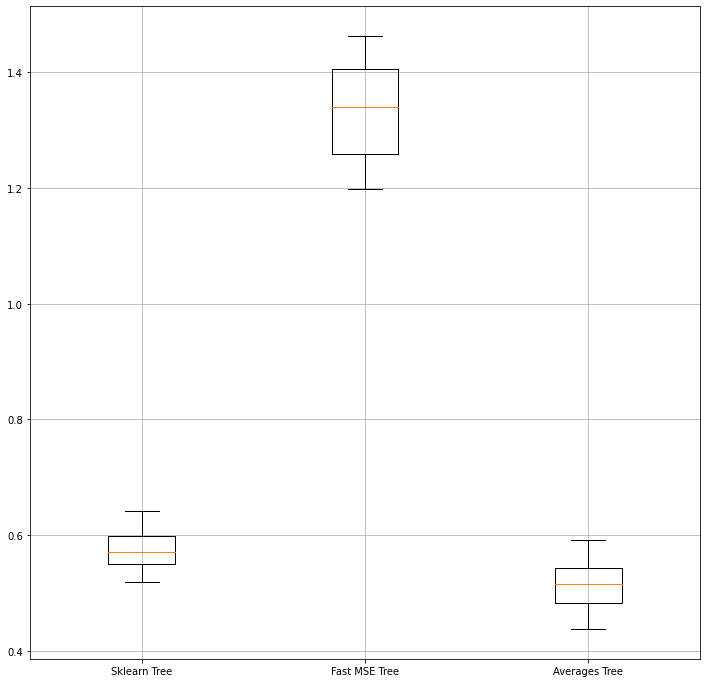

In [18]:
import matplotlib.pyplot as plt

%matplotlib inline

data = [er_sklearn_tree, er_fast_mse_tree, er_averages_tree]
fig7, ax7 = plt.subplots(figsize=(12, 12))
ax7.set_title('')
ax7.boxplot(data, labels=['Sklearn Tree', 'Fast MSE Tree', 'Averages Tree'])
plt.grid()
plt.show()